In [5]:
# Imports
import pandas as pd
import numpy as np
from plotnine import ggplot
import matplotlib.pyplot as plt
import scipy

# 1. Distributions and Outliers

In [6]:
# Importing the data
heart_rate = pd.read_csv("./fitabase-data/heartrate_seconds_merged.csv")
sleep_duration = pd.read_csv("./fitabase-data/sleepDay_merged.csv")
daily_steps = pd.read_csv("./fitabase-data/dailySteps_merged.csv")
weight_change = pd.read_csv("./fitabase-data/weightLogInfo_merged.csv")

# Displaying the data
# display(heart_rate)
# display(sleep_duration)
# display(daily_steps)
# display(weight_change)

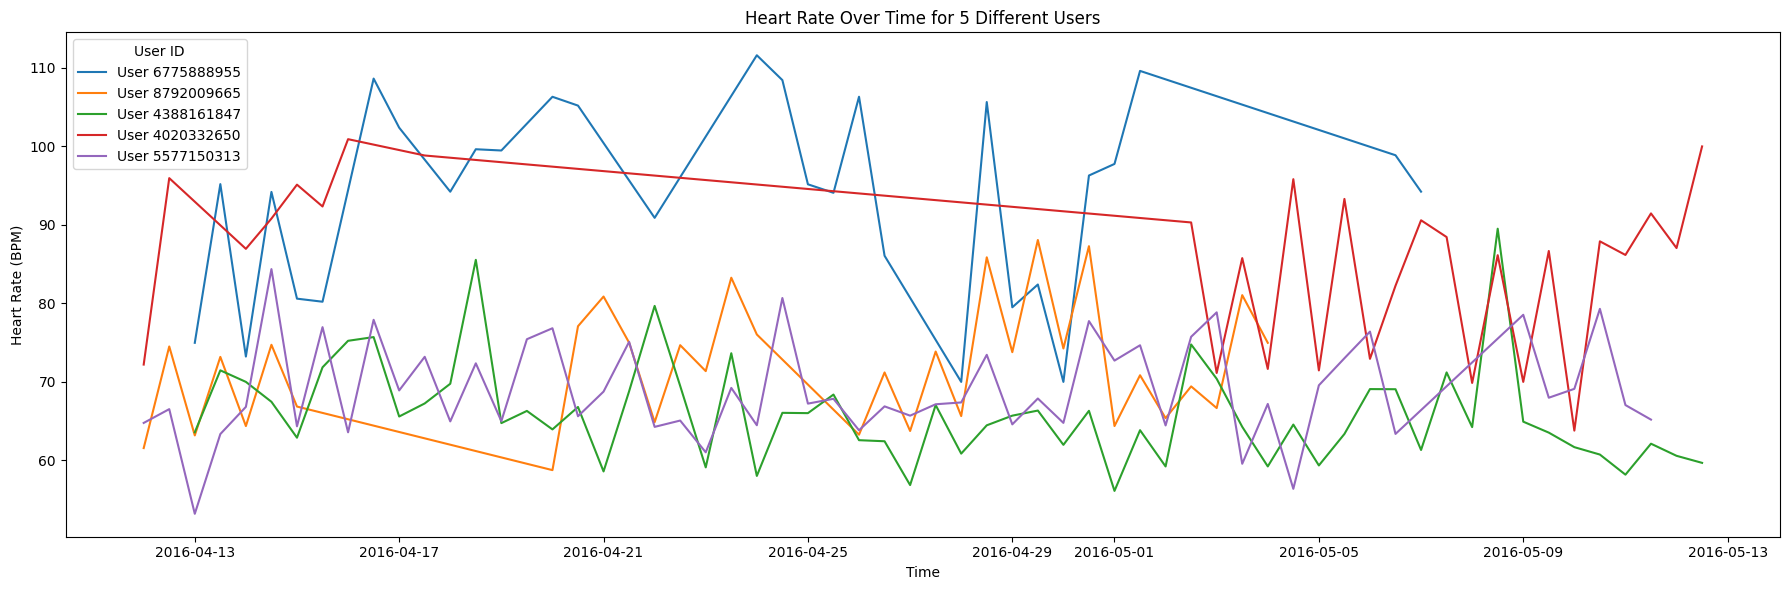

In [7]:
# 1(a) heart rate for 5 different users (user determined by ID)

heart_rate_grouped = heart_rate.groupby("Id")
user_ids = list(heart_rate_grouped.groups.keys())
# select 5 random unique users
np.random.seed(57)
selected_users = np.random.choice(user_ids, 5, replace = False)

# convert time column to datetime
heart_rate["Time"] = pd.to_datetime(heart_rate["Time"])

# find the selected users in the heart_rate_grouped data
heart_rate_subset = heart_rate[heart_rate["Id"].isin(selected_users)]

# downsample the subset to 12 hour intervals by averaging
heart_rate_subset = (
    heart_rate_subset
    .groupby(["Id", pd.Grouper(key="Time", freq="12h")])["Value"] # groups of data for each user in 12H timeframes
    .mean() # takes the mean of the heart rate in the 12H timeframe
    .reset_index()
)

# display(heart_rate_subset)
# print("Selected User IDs:", sorted(selected_users))

# plotting the users' heart rates
plt.figure(figsize=(18,6))
for id in selected_users:
  user_data = heart_rate_subset[heart_rate_subset["Id"] == id]
  plt.plot(user_data["Time"], user_data["Value"], label=f"User {id}")

plt.title("Heart Rate Over Time for 5 Different Users")
plt.xlabel("Time")
plt.ylabel("Heart Rate (BPM)")
plt.legend(title = "User ID")
plt.tight_layout()
plt.show()

/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/3159212640.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


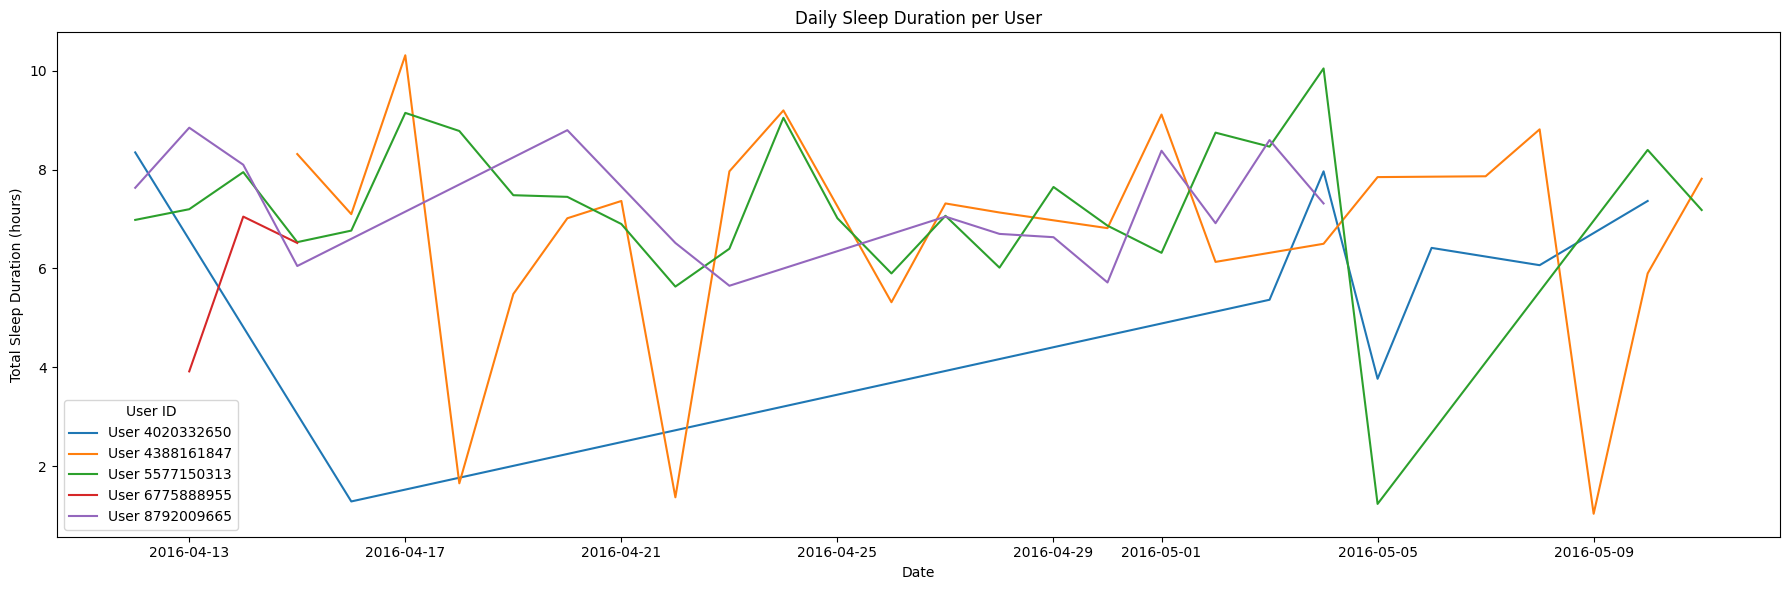

In [8]:
# 1(b) daily sleep duration for 5 different users
# utilizing same 5 selected users in part 1(a)

# convert SleepDay field to datetime
sleep_duration["SleepDay"] = pd.to_datetime(sleep_duration["SleepDay"])

# convert minutes to hours
sleep_duration["TotalHoursAsleep"] = sleep_duration["TotalMinutesAsleep"] / 60
sleep_duration["TotalHoursInBed"] = sleep_duration["TotalTimeInBed"] / 60

# finds the selected users in the sleep_duration_grouped data
sleep_duration_subset = sleep_duration[sleep_duration["Id"].isin(selected_users)]
sleep_duration_grouped = sleep_duration_subset.groupby("Id")

# plot daily sleep durations
plt.figure(figsize=(18, 6))
for user_id, user_data in sleep_duration_grouped:
    plt.plot(user_data["SleepDay"], user_data["TotalHoursAsleep"], label=f"User {user_id}")

# Customize plot
plt.title("Daily Sleep Duration per User")
plt.xlabel("Date")
plt.ylabel("Total Sleep Duration (hours)")
plt.legend(title="User ID")
plt.tight_layout()
plt.show()

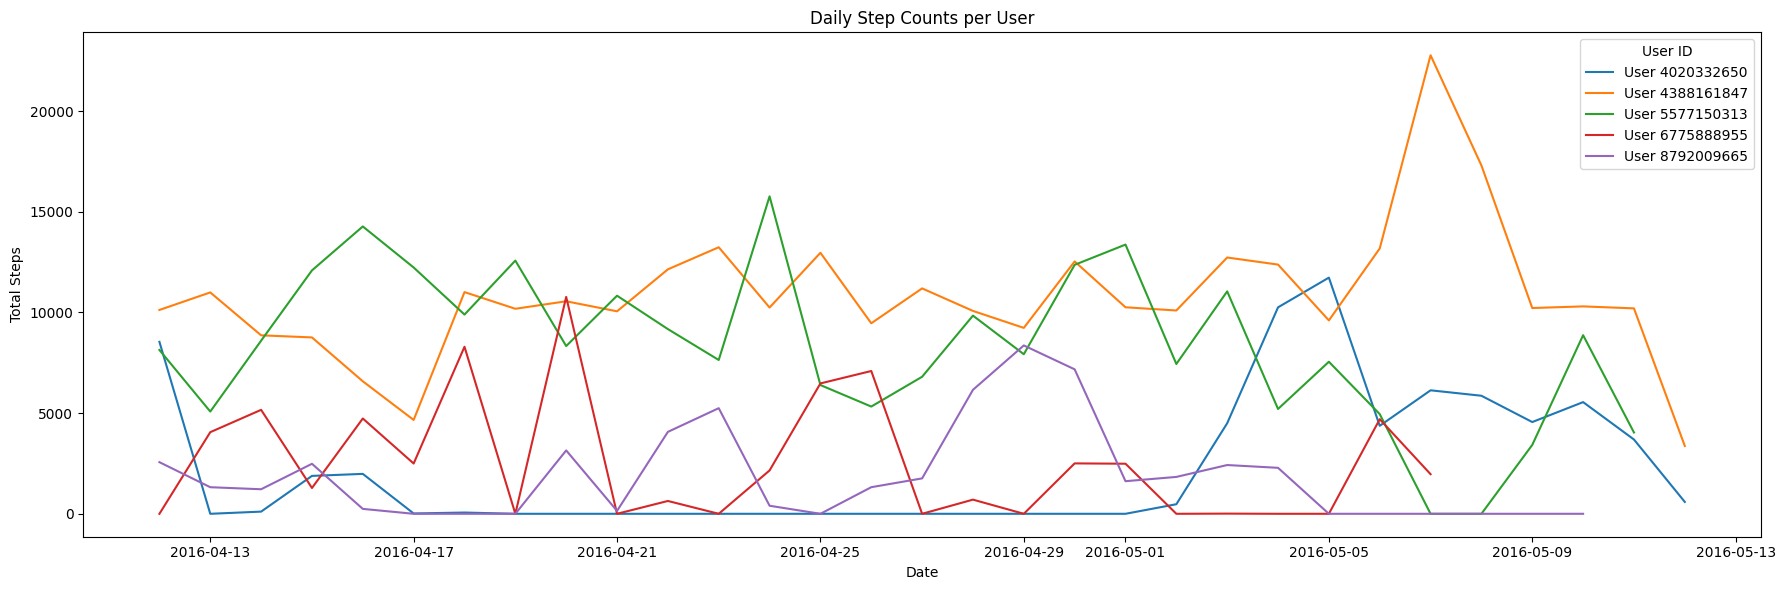

In [9]:
# 1(c) daily steps for 5 different users
# utilizing same 5 selected users in part 1(a)

# convert ActivityDay to datetime
daily_steps["ActivityDay"] = pd.to_datetime(daily_steps["ActivityDay"])

# finds the selected users in the daily_steps data
daily_steps_subset = daily_steps[daily_steps["Id"].isin(selected_users)]
daily_steps_grouped = daily_steps_subset.groupby("Id")

# plot daily steps for the 5 users
plt.figure(figsize=(18,6))

for user_id, user_data in daily_steps_grouped:
  plt.plot(user_data["ActivityDay"], user_data["StepTotal"], label=f"User {user_id}")

plt.title("Daily Step Counts per User")
plt.xlabel("Date")
plt.ylabel("Total Steps")
plt.legend(title="User ID")
plt.tight_layout()
plt.show()

/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/2066901589.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


6962181067


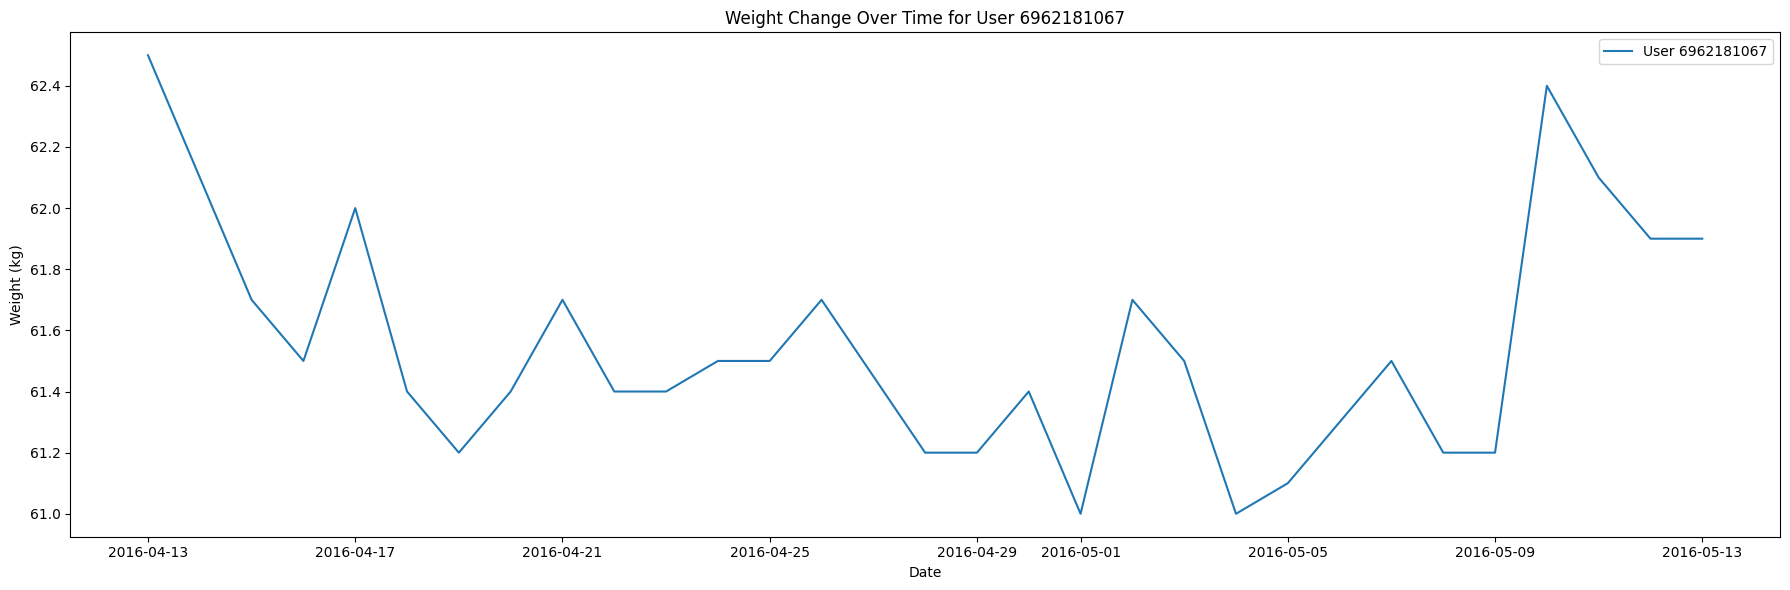

In [10]:
# 1(d) weight change of the user with the highest number of weight recorded
# converting Date to datetime

weight_change["Date"] = pd.to_datetime(weight_change["Date"])

# find user with highest number of weight records
top_user_id = weight_change["Id"].value_counts().idxmax()
print(top_user_id)

# obtain the top_user's data
top_user_data = weight_change[weight_change["Id"] == top_user_id]

# plot weight change for the top user
plt.figure(figsize=(18,6))
plt.plot(top_user_data["Date"], top_user_data["WeightKg"], label=f"User {top_user_id}")

plt.title(f"Weight Change Over Time for User {top_user_id}")
plt.xlabel("Date")
plt.ylabel("Weight (kg)")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Data Processing

In [11]:
# 2(a) Create dataframes merging information from multiple datasets

#####
# HOURLY
#####
hour_step = pd.read_csv("./fitabase-data/hourlySteps_merged.csv")
hour_intensity = pd.read_csv("./fitabase-data/hourlyIntensities_merged.csv")
hour_calories = pd.read_csv("./fitabase-data/hourlyCalories_merged.csv")

hour_step_intensity = hour_step.merge(hour_intensity, on=["Id", "ActivityHour"])
hourly_merged = hour_step_intensity.merge(hour_calories, on=["Id", "ActivityHour"])

# display(hourly_merged)

#####
# MINUTELY
#####
min_calories = pd.read_csv("./fitabase-data/minuteCaloriesNarrow_merged.csv")
min_intensity = pd.read_csv("./fitabase-data/minuteIntensitiesNarrow_merged.csv")
min_mets = pd.read_csv("./fitabase-data/minuteMETsNarrow_merged.csv")

min_calories_intensity = min_calories.merge(min_intensity, on=["Id", "ActivityMinute"])
minutely_merged = min_calories_intensity.merge(min_mets, on=["Id", "ActivityMinute"])

# display(minutely_merged)

In [12]:
# 2(b) Convert time strings to datetime type

daily_activity = pd.read_csv("./fitabase-data/dailyActivity_merged.csv")
sleep_day = pd.read_csv("./fitabase-data/sleepDay_merged.csv")

# daily activity to datetime
daily_activity["Date"] = pd.to_datetime(daily_activity["ActivityDate"])

# sleep day data to datetime
sleep_day["Date"] = pd.to_datetime(sleep_day["SleepDay"])

# hourly merged to datetime
hourly_merged["Date"] = pd.to_datetime(hourly_merged["ActivityHour"])

# minutely merged to datetime
minutely_merged["Date"] = pd.to_datetime(minutely_merged["ActivityMinute"])

# quick look
# display(daily_activity.head())
# display(sleep_day.head())
# display(hourly_merged.head())
# display(minutely_merged.head())

/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/2435088514.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/2435088514.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/2435088514.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [14]:
# 2(c) Process heart rate data

heart_rate_seconds = pd.read_csv("./fitabase-data/heartrate_seconds_merged.csv")

# convert Time to datetime
heart_rate_seconds["Time"] = pd.to_datetime(heart_rate_seconds["Time"])
# floor to nearest minute
heart_rate_seconds["Date"] = heart_rate_seconds["Time"].dt.floor("T")

# calculate avg heart rate per min per user
# group by Id and Date operate on Value
target_grouped = heart_rate_seconds.groupby(["Id", "Date"])["Value"]
target_grouped_mean = target_grouped.mean()
# reset indices and rename
hr_per_min = target_grouped_mean.reset_index()
hr_per_min = hr_per_min.rename(columns={"Value": "hr_per_min"})

# update Date to match
minutely_merged["Date"] = pd.to_datetime(minutely_merged["Date"]).dt.floor("T")
# add as new column in minutely dataframe
minutely_with_hr = minutely_merged.merge(hr_per_min, on=["Id", "Date"], how="left")

# display(minutely_merged.head())
# display(minutely_merged.tail())


/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/404792476.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_35167/404792476.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.


# 3. Correlation and Plots

# 4. T-tests